In [1]:
import numpy as np
import pandas as pd
from scipy.stats import trim_mean
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
ticker.EngFormatter.ENG_PREFIXES.update({9:"B"}) # For cleaner formatting
sns.set()

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [7]:
# Data processing for raw data
# NOTE: data not available in public repo; we only provide aggregate stats
import os

mt = None
csv_dir = "data/mt80_results"
print(f"Found {len(os.listdir(csv_dir))} files in {csv_dir}") 
for file in os.listdir(csv_dir):
    if file.endswith(".csv"):
        task = file.split("_")[0]
        file_path = os.path.join(csv_dir, file)
        print(f"loading {file_path}")
        df = pd.read_csv(file_path)
        df = df.rename({f"episode_reward+{task}": "episode_reward", f"episode_success+{task}": "episode_success"}, axis=1)
        df["task"] = task
        df = df.dropna(how="all", axis=1)
        df = df.dropna()
        if mt is None:
            mt = df
        else:
            mt = pd.concat((mt, df))
        # break

len(mt)
mt.to_csv(f"{csv_dir}.csv")
mt

Found 77 files in data/mt80_results_h3
loading data/mt80_results_h3/cartpole-swingup-sparse_results.csv
loading data/mt80_results_h3/mw-push-wall_results.csv
loading data/mt80_results_h3/mw-assembly_results.csv
loading data/mt80_results_h3/mw-button-press-topdown_results.csv
loading data/mt80_results_h3/mw-plate-slide-back-side_results.csv
loading data/mt80_results_h3/mw-plate-slide_results.csv
loading data/mt80_results_h3/mw-hammer_results.csv
loading data/mt80_results_h3/mw-soccer_results.csv
loading data/mt80_results_h3/finger-turn-hard_results.csv
loading data/mt80_results_h3/cheetah-run-back_results.csv
loading data/mt80_results_h3/mw-pick-place-wall_results.csv
loading data/mt80_results_h3/mw-lever-pull_results.csv
loading data/mt80_results_h3/mw-peg-unplug-side_results.csv
loading data/mt80_results_h3/mw-button-press-topdown-wall_results.csv
loading data/mt80_results_h3/mw-plate-slide-back_results.csv
loading data/mt80_results_h3/acrobot-swingup_results.csv
loading data/mt80_res

,Unnamed: 0,iteration,total_time,actor_loss,value_loss,actor_grad_norm,critic_grad_norm,episode_reward,episode_success,_timestamp,_runtime,episode_reward_planning,episode_success_planning,task
1000,1000,99999,13608.142159,-2.011164,1.048436,0.030510,5.062525e+00,91.400002,0.0,1716338695,13976,182.800003,0.0,cartpole-swingup-sparse
1000,1000,99999,14489.547533,-6.318641,0.013290,0.008300,1.212707e+00,1605.125732,1.0,1716324749,14680,1529.599854,1.0,mw-push-wall
1000,1000,99999,12772.533344,-2.407802,79.774635,0.119348,1.950612e+02,758.455505,0.4,1716346348,12977,192.719757,0.0,mw-assembly
1000,1000,99999,12702.965794,2.316653,394277.968750,0.408028,1.254197e+06,1218.781006,1.0,1716346278,12873,151.309906,0.0,mw-button-press-topdown
1000,1000,99999,13202.578967,-0.783036,11668.436523,0.088797,4.372859e+04,1660.006104,0.9,1716323328,13361,1472.283936,0.8,mw-plate-slide-back-side
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,1000,99999,12734.588292,-0.645857,416372.562500,0.033327,8.910594e+05,1196.988770,0.6,1716322401,12916,498.700928,0.0,mw-faucet-open
1000,1000,99999,13003.066766,-0.480336,690.424133,0.080502,2.120360e+03,1814.714478,1.0,1716322763,13184,1117.372192,0.6,mw-handle-press-side
1000,1000,99999,12738.851910,-1.932739,0.288738,0.007718,6.354257e+00,1342.303711,0.2,1716323046,12916,1739.807983,0.0,mw-reach-wall
1000,1000,99999,12721.385195,-18.208179,0.000874,0.008036,4.990758e-01,993.639771,0.0,1716337501,13102,982.268738,0.0,walker-stand


In [2]:
# DreamerV3 
dreamerv3_data = pd.read_json("data/dmc_proprio-dreamerv3.json")
dreamerv3_data = dreamerv3_data[['task', 'ys']]
dreamerv3_data['episode_reward'] = dreamerv3_data['ys'].apply(lambda x: np.max(x))

# PPO
ppo_data = pd.read_json("data/dmc_proprio-ppo_fixhp.json")
ppo_data = ppo_data[['task', 'ys']]
ppo_data['episode_reward'] = ppo_data['ys'].apply(lambda x: np.max(x))

# SAC
sac_data = pd.read_csv("data/sac.csv")
# seperate unique run_id's into a list
run_ids = sac_data['run_id'].unique()
# create pandas dataframe to with columns "task" and "episode_reward"
temp = pd.DataFrame(columns=['task', 'episode_reward'])
for run_id in run_ids:
    # get all the data for the current run_id
    data = sac_data[sac_data['run_id'] == run_id]
    # get the task name
    task = data['env'].values[0]
    
    # get the episode reward
    episode_reward = data['episode_reward'].max()
    # add the task and episode reward to the temp dataframe
    temp = pd.concat([temp, pd.DataFrame({'task': [task], 'episode_reward': [episode_reward]})])
sac_data = temp

In [3]:
# Load data and process into metrics
pwm_data = pd.read_csv("data/fowm_mt30_h3_results.csv")
tdmpc_data = pd.read_csv("data/tdmpc2_mt30_scores.csv")
seeds = tdmpc_data.seed.max()+1
tdmpc_scores = tdmpc_data.episode_reward.values.reshape((-1, seeds, 1))

# score dict is {algo: np.array num_exp x seeds x episode_rewards}
norm = 1000
score_dict = {
            "TDMPC2": tdmpc_scores/norm,         
            "PWM": pwm_data.best_reward.values.astype(np.float32)[...,None][...,None]/norm,
             # "PWM+planning": pwm_data.episode_reward_planning.values.astype(np.float32)[...,None][...,None]/norm,
             "TDMPC2": tdmpc_scores/norm,
             # "PPO": ppo_data.episode_reward.values.astype(np.float32)[..., None][..., None]/norm,
             "SAC": sac_data.episode_reward.values.astype(np.float32)[..., None][..., None]/norm,
             "DreamerV3": dreamerv3_data.episode_reward.values.reshape((-1, 5, 1))/norm,
            }

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])

tau = np.linspace(0.0, 1.0, 100)
reps = 2000
score_distributions, score_distributions_cis = rly.create_performance_profile(score_dict, tau, reps=reps)
iqm_scores, iqm_cis = rly.get_interval_estimates(score_dict, iqm, reps=reps)
mean_scores = {algo: np.mean(scores) for algo,scores in score_dict.items()} 


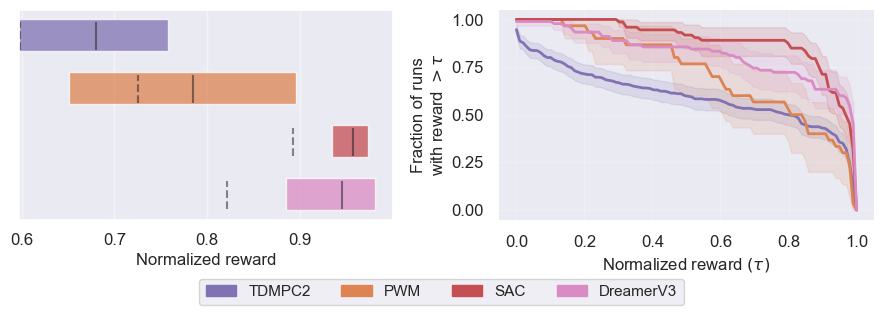

In [4]:
# Load data and process into metrics
pwm_data = pd.read_csv("data/fowm_mt30_h3_results.csv")
tdmpc_data = pd.read_csv("data/tdmpc2_mt30_scores.csv")
seeds = tdmpc_data.seed.max()+1
tdmpc_scores = tdmpc_data.episode_reward.values.reshape((-1, seeds, 1))

# score dict is {algo: np.array num_exp x seeds x episode_rewards}
norm = 1000
score_dict = {
            "TDMPC2": tdmpc_scores/norm,         
            "PWM": pwm_data.best_reward.values.astype(np.float32)[...,None][...,None]/norm,
             # "PWM+planning": pwm_data.episode_reward_planning.values.astype(np.float32)[...,None][...,None]/norm,
             "TDMPC2": tdmpc_scores/norm,
             # "PPO": ppo_data.episode_reward.values.astype(np.float32)[..., None][..., None]/norm,
             "SAC": sac_data.episode_reward.values.astype(np.float32)[..., None][..., None]/norm,
             "DreamerV3": dreamerv3_data.episode_reward.values.reshape((-1, 5, 1))/norm,
            }

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])

tau = np.linspace(0.0, 1.0, 100)
reps = 2000
score_distributions, score_distributions_cis = rly.create_performance_profile(score_dict, tau, reps=reps)
iqm_scores, iqm_cis = rly.get_interval_estimates(score_dict, iqm, reps=reps)
mean_scores = {algo: np.mean(scores) for algo,scores in score_dict.items()} 


# Plot data
colors = sns.color_palette()

# baselines are PPO, SAC, TDMPC (no planning), TDMPC plannig, SHAC, FOWM
colors = {#"SHAC": colors[0],
         # "PPO": colors[2],
         "TDMPC2": colors[4],
         "PWM": colors[1],
         "SAC": colors[3],
         # "PWM+planning": colors[5],
         "DreamerV3": colors[6]}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 3))

# plot CI and median
h=0.6
labels = ["PPO", "SAC", "TDMPC2", "PWM", "PWM+planning", "DreamerV3"][::-1]
labels = ["TDMPC2", "PWM", "SAC", "DreamerV3"][::-1]
for idx, alg in enumerate(labels):
    ax1.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], alpha=0.75, color=colors[alg])
    ax1.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax1.vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

ax1.set_xlabel("Normalized reward")
ax1.grid(False)    
ax1.grid(True, axis='x', alpha=0.5)    
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize='medium')
# ax1.set_xlim((0.8, 1.47))

# remove for figure
plot_utils.plot_performance_profiles(
  score_distributions, tau,
  performance_profile_cis=score_distributions_cis,
  colors=colors,
  xlabel=r'Normalized reward $(\tau)$',
  labelsize='medium',
  ax=ax2)
ax2.tick_params(axis='both', which='major', labelsize='medium', pad=1.3)
ax2.set_xlabel(r'Normalized reward $(\tau)$', fontsize='medium')
ax2.set_ylabel('Fraction of runs\nwith reward $> \\tau$', fontsize='medium')

# set legened helpers
fancy_legend = []
for k in colors.keys():
    patch = mpatches.Patch(color=colors[k], label=k)
    fancy_legend.append(patch)

plt.tight_layout()
fig.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, 0.0), fancybox=True, shadow=False, ncol=len(fancy_legend))
plt.savefig("../figures/mutlitask.pdf", bbox_inches="tight")

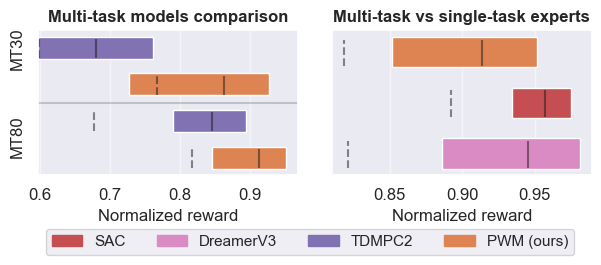

In [26]:
# Load data and process into metrics

pwm_data = pd.read_csv("data/mt80_results.csv")
pwm_data["score"] = pwm_data.episode_reward/norm
idx = pwm_data.task.str.startswith("mw")
pwm_data.loc[idx, "score"] = pwm_data[idx].episode_success

# score dict is {algo: np.array num_exp x seeds x episode_rewards}
norm = 1000
score_dict = {
            "PWM": pwm_data.score.values.astype(np.float32)[...,None,None],
             "SAC": sac_data.episode_reward.values.astype(np.float32)[..., None][..., None]/norm,
             "DreamerV3": dreamerv3_data.episode_reward.values.reshape((-1, 5, 1))/norm,
            }

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])

tau = np.linspace(0.0, 1.0, 100)
reps = 2000
score_distributions, score_distributions_cis = rly.create_performance_profile(score_dict, tau, reps=reps)
iqm_scores, iqm_cis = rly.get_interval_estimates(score_dict, iqm, reps=reps)
mean_scores = {algo: np.mean(scores) for algo,scores in score_dict.items()} 


# Plot data
colors = sns.color_palette()

# baselines are PPO, SAC, TDMPC (no planning), TDMPC plannig, SHAC, FOWM
colors = {#"SHAC": colors[0],
         # "PPO": colors[2],
         "TDMPC2": colors[4],
         "PWM": colors[1],
         "SAC": colors[3],
         # "PWM+planning": colors[5],
         "DreamerV3": colors[6]}

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(6, 2.5))

# plot CI and median
h=0.6
labels = ["PWM", "SAC", "DreamerV3"][::-1]
for idx, alg in enumerate(labels):
    ax1.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], color=colors[alg])
    ax1.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax1.vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

ax1.set_xlabel("Normalized reward")
ax1.grid(False)    
ax1.grid(True, axis='x', alpha=0.5)    
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize='medium')

# Load data and process into metrics
norm = 1000

pwm30_data = pd.read_csv("data/mt30_results.csv")
pwm30_data["score"] = pwm30_data.episode_reward/norm

pwm80_data = pd.read_csv("data/mt80_results.csv")
pwm80_data["score"] = pwm80_data.episode_reward/norm
idx = pwm80_data.task.str.startswith("mw")
pwm80_data.loc[idx, "score"] = pwm80_data[idx].episode_success

tdmpc30_data = pd.read_csv("data/tdmpc2_mt30_scores.csv")
seeds = tdmpc30_data.seed.max()+1
tdmpc30_scores = tdmpc30_data.episode_reward.values.reshape((-1, seeds, 1))

tdmpc80_data = pd.read_csv("data/tdmpc2_mt80_scores.csv")
tdmpc80_data["score"] = tdmpc80_data.episode_reward/norm
idx = tdmpc80_data.task.str.startswith("mw")
tdmpc80_data.loc[idx, "score"] = tdmpc80_data[idx].episode_success
seeds = tdmpc80_data.seed.max()+1
tdmpc80_scores = tdmpc80_data.score.values.reshape((-1, seeds, 1))

# score dict is {algo: np.array num_exp x seeds x episode_rewards}
score_dict = {
            "TDMPC230": tdmpc30_scores/norm,
            "TDMPC280": tdmpc80_scores,
            "PWM30": pwm30_data.score.values.astype(np.float32)[...,None][...,None],
            "PWM80": pwm80_data.score.values.astype(np.float32)[...,None][...,None],
            }

iqm_scores, iqm_cis = rly.get_interval_estimates(score_dict, iqm, reps=reps)
mean_scores = {algo: np.mean(scores) for algo,scores in score_dict.items()} 

# Plot data
colors = sns.color_palette()

# baselines are PPO, SAC, TDMPC (no planning), TDMPC plannig, SHAC, FOWM
colors = {#"SHAC": colors[0],
         # "PPO": colors[2],
         "TDMPC230": colors[4],
         "TDMPC280": colors[4],
         "TDMPC2": colors[4],
         "PWM30": colors[1],
         "PWM80": colors[1],
         "PWM": colors[1],
         "SAC": colors[3],
         # "PWM+planning": colors[5],
         "DreamerV3": colors[6]}

# plot CI and median
h=0.6
labels = ["TDMPC230", "PWM30"][::-1]
for idx, alg in enumerate(labels):
    idx += 2
    ax0.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], color=colors[alg])
    ax0.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax0.vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

labels = ["TDMPC280", "PWM80"][::-1]
for idx, alg in enumerate(labels):
    ax0.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], color=colors[alg])
    ax0.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax0.vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

ax0.set_xlabel("Normalized reward")
ax0.grid(False)    
ax0.grid(True, axis='x', alpha=0.5)    
ax0.set_yticks([])
ax0.tick_params(axis='both', which='major', labelsize='medium')

xlim = ax0.get_xlim()
ax0.hlines(1.5, xlim[0], xlim[1], color="k", alpha=0.2)
ax0.set_xlim(xlim)
fig.text(0, 0.7, "MT30", rotation=90)
fig.text(0, 0.35, "MT80", rotation=90)


# set legened helpers
fancy_legend = []
# for k in colors.keys():
for k in ["SAC", "DreamerV3", "TDMPC2", "PWM"]:
    if k == "PWM":
        patch = mpatches.Patch(color=colors[k], label="PWM (ours)")
    else:
        patch = mpatches.Patch(color=colors[k], label=k)
    fancy_legend.append(patch)

ax0.set_title("Multi-task models comparison", fontweight="bold")
ax1.set_title("Multi-task vs single-task experts", fontweight="bold")


plt.tight_layout(w_pad=2.0)
fig.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, 0.0), fancybox=True, shadow=False, ncol=len(fancy_legend))
plt.savefig("../figures/mutlitask_full.png", bbox_inches="tight", pad_inches=0)

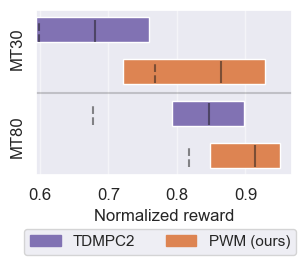

In [21]:
# Load data and process into metrics
norm = 1000

pwm30_data = pd.read_csv("data/mt30_results.csv")
pwm30_data["score"] = pwm30_data.episode_reward/norm

pwm80_data = pd.read_csv("data/mt80_results.csv")
pwm80_data["score"] = pwm80_data.episode_reward/norm
idx = pwm80_data.task.str.startswith("mw")
pwm80_data.loc[idx, "score"] = pwm80_data[idx].episode_success


tdmpc30_data = pd.read_csv("data/tdmpc2_mt30_scores.csv")
seeds = tdmpc30_data.seed.max()+1
tdmpc30_scores = tdmpc30_data.episode_reward.values.reshape((-1, seeds, 1))

tdmpc80_data = pd.read_csv("data/tdmpc2_mt80_scores.csv")
tdmpc80_data["score"] = tdmpc80_data.episode_reward/norm
idx = tdmpc80_data.task.str.startswith("mw")
tdmpc80_data.loc[idx, "score"] = tdmpc80_data[idx].episode_success
seeds = tdmpc80_data.seed.max()+1
tdmpc80_scores = tdmpc80_data.score.values.reshape((-1, seeds, 1))

# score dict is {algo: np.array num_exp x seeds x episode_rewards}
score_dict = {
            "TDMPC230": tdmpc30_scores/norm,
            "TDMPC280": tdmpc80_scores,
            "PWM30": pwm30_data.score.values.astype(np.float32)[...,None][...,None],
            "PWM80": pwm80_data.score.values.astype(np.float32)[...,None][...,None],
            }

iqm_scores, iqm_cis = rly.get_interval_estimates(score_dict, iqm, reps=reps)
mean_scores = {algo: np.mean(scores) for algo,scores in score_dict.items()} 

# Plot data
colors = sns.color_palette()

# baselines are PPO, SAC, TDMPC (no planning), TDMPC plannig, SHAC, FOWM
colors = {#"SHAC": colors[0],
         # "PPO": colors[2],
         "TDMPC230": colors[4],
         "TDMPC280": colors[4],
         "PWM30": colors[1],
         "PWM80": colors[1],
         "SAC": colors[3],
         # "PWM+planning": colors[5],
         "DreamerV3": colors[6]}

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 3))
fig, ax1 = plt.subplots(1,1, figsize=(3,2.5))

# plot CI and median
h=0.6
labels = ["TDMPC230", "PWM30"][::-1]
for idx, alg in enumerate(labels):
    idx += 2
    ax1.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], color=colors[alg])
    ax1.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax1.vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

labels = ["TDMPC280", "PWM80"][::-1]
for idx, alg in enumerate(labels):
    ax1.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], color=colors[alg])
    ax1.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax1.vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

ax1.set_xlabel("Normalized reward")
ax1.grid(False)    
ax1.grid(True, axis='x', alpha=0.5)    
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize='medium')

xlim = ax1.get_xlim()
ax1.hlines(1.5, xlim[0], xlim[1], color="k", alpha=0.2)
ax1.set_xlim(xlim)
fig.text(0, 0.7, "MT30", rotation=90)
fig.text(0, 0.35, "MT80", rotation=90)


# set legened helpers
fancy_legend = [mpatches.Patch(color=colors["TDMPC230"], label="TDMPC2"),
               mpatches.Patch(color=colors["PWM80"], label="PWM (ours)")]

plt.tight_layout()
fig.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, 0.0), fancybox=True, shadow=False, ncol=len(fancy_legend))
plt.savefig("../figures/mutlitask.pdf", bbox_inches="tight", pad_inches=0)

KeyError: 'PWM'

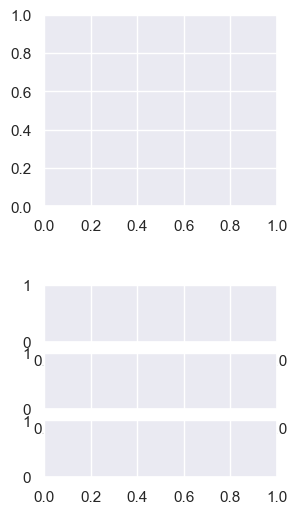

In [22]:
# Plot data
colors = sns.color_palette()

# baselines are PPO, SAC, TDMPC (no planning), TDMPC plannig, SHAC, FOWM
colors = {#"SHAC": colors[0],
         # "PPO": colors[2],
         "TDMPC2": colors[4],
         "PWM": colors[1],
         "SAC": colors[3],
         # "PWM+planning": colors[5],
         "DreamerV3": colors[6]}

mosaic = """000
000
000
...
111
222
333
"""
fig, ax = plt.subplot_mosaic(mosaic, figsize=(3,6), sharey=False)

# plot CI and median
h=0.6
labels = ["PPO", "SAC", "TDMPC2", "PWM", "PWM+planning", "DreamerV3"][::-1]
labels = ["TDMPC2", "PWM"][::-1]
for idx, alg in enumerate(labels):
    idx += 2
    ax['0'].barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], color=colors[alg])
    ax['0'].vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax['0'].vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

labels = ["TDMPC2", "PWM"][::-1]
fake_add = 0.1
for idx, alg in enumerate(labels):
    ax['0'].barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0]+fake_add, color=colors[alg])
    ax['0'].vlines(x=iqm_scores[alg]+fake_add,
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax['0'].vlines(x=mean_scores[alg]+fake_add,
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

ax['0'].set_xlabel("Normalized reward")
ax['0'].grid(False)    
ax['0'].grid(True, axis='x', alpha=0.5)    
ax['0'].set_yticks([])
ax['0'].tick_params(axis='both', which='major', labelsize='medium')

xlim = ax['0'].get_xlim()
ax['0'].hlines(1.5, xlim[0], xlim[1], color="k", alpha=0.2)
ax['0'].set_xlim(xlim)

clss = [colors["TDMPC2"], colors["PWM"]][::-1]
train_times = np.array([1.0, 1.36])
train_times /= train_times.max()/80
ax['1'].barh(range(len(train_times)), train_times, color=clss)
ax['1'].set_title("World model pre-training", fontsize="small")
ax['1'].set_yticks([])
ax['1'].xaxis.set_ticklabels([])

train_times = [1, 0]
ax['2'].barh(range(len(train_times)), train_times, color=clss)
ax['2'].set_title("Policy training", fontsize="small")
ax['2'].set_yticks([])
ax['2'].xaxis.set_ticklabels([])

inference_time = np.array([0.000813, 0.064468])
inference_time /= inference_time.min()
ax['3'].barh(range(len(inference_time)), inference_time, color=clss)
ax['3'].set_title("Inference", fontsize="small")
ax['3'].set_yticks([])
ax['3'].set_xlabel("Normalized time")

xlim = ax['3'].get_xlim()
for a in ['1', '2']:
    ax[a].set_xlim(xlim)


# set legened helpers
fancy_legend = []
# for k in colors.keys():
for k in labels[::-1]:
    if k == "PWM":
        patch = mpatches.Patch(color=colors[k], label="PWM (ours)")
    else:
        patch = mpatches.Patch(color=colors[k], label=k)
    fancy_legend.append(patch)

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=-1.2)
fig.text(-0.04, 0.88, "MT30", rotation=90)
fig.text(-0.04, 0.7, "MT80", rotation=90)
fig.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, 0.51), fancybox=True, shadow=False, ncol=len(fancy_legend))
plt.savefig("../figures/mutlitask_w_times.pdf", bbox_inches="tight", pad_inches=0)

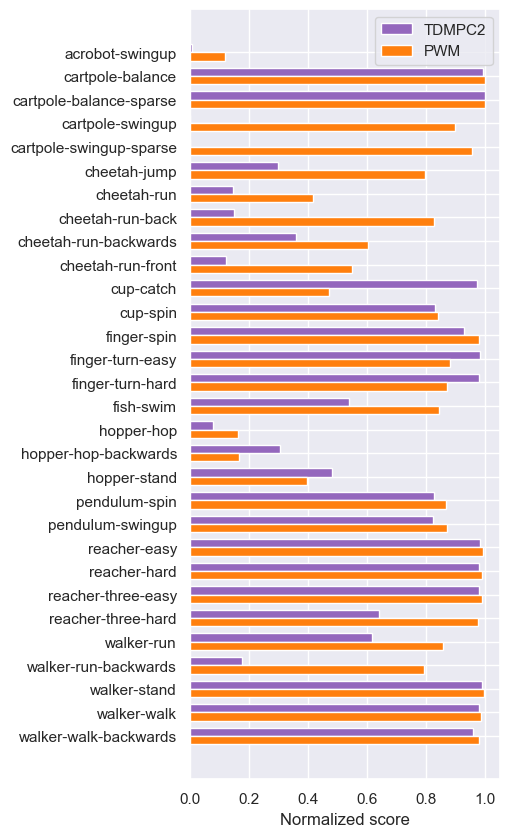

In [34]:
tdmpc30_data = pd.read_csv("data/tdmpc2_mt30_scores.csv")
tdmpc30_data = tdmpc30_data.sort_values(by="task")
seeds = tdmpc30_data.seed.max()+1
tdmpc30_scores = tdmpc30_data.episode_reward.values.reshape((-1, seeds, 1))


# Sample data
# categories = ['Apple', 'Banana', 'Cherry', 'Date', 'Elderberry']
tasks = tdmpc30_data.task.unique()
tdmpc_scores = trim_mean(tdmpc30_scores, proportiontocut=0.25, axis=1).squeeze()

pwm30_data = pd.read_csv("data/mt30_results.csv")
pwm30_data = pwm30_data.sort_values(by="task")
pwm_30_scores = pwm30_data.episode_reward

# Define the positions for the categories
y_positions = np.arange(len(tasks))

# Bar width
bar_width = 0.35

# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(4, 10))

# Plotting data
bars1 = ax.barh(y_positions - bar_width/2, tdmpc_scores/1000, bar_width, label='TDMPC2', color='tab:purple')
bars2 = ax.barh(y_positions + bar_width/2, pwm_30_scores/1000, bar_width, label='PWM', color='tab:orange')

# Setting labels and title
ax.set_xlabel('Normalized score')
# ax.set_title('Comparison of Algorithms Across Categories')
ax.set_yticks(y_positions)
ax.set_yticklabels(tasks)
ax.legend()

# Invert y-axis
ax.invert_yaxis()
plt.savefig("../figures/mt30_individual.pdf", bbox_inches="tight", pad_inches=0)

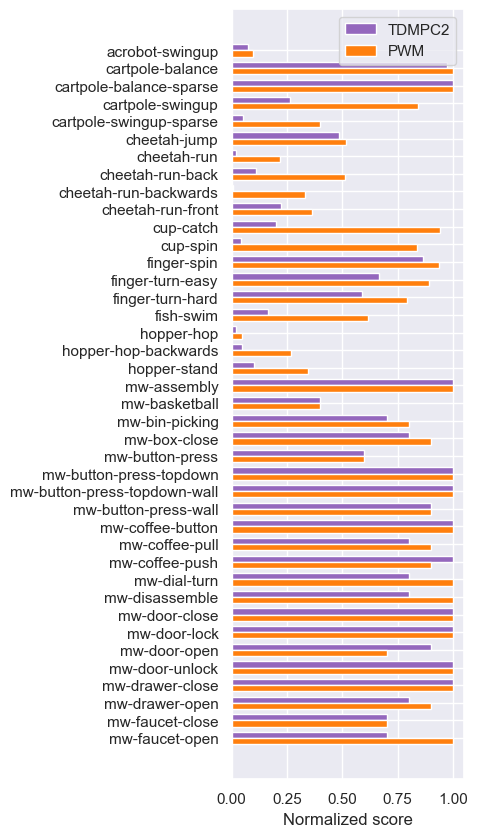

In [32]:
norm = 1000
tdmpc_data = pd.read_csv("data/tdmpc2_mt80_scores.csv")
tdmpc_data = tdmpc_data.sort_values(by="task")
seeds = tdmpc_data.seed.max()+1
tdmpc_data["score"] = tdmpc_data.episode_reward/norm
idx = tdmpc_data.task.str.startswith("mw")
tdmpc_data.loc[idx, "score"] = tdmpc_data[idx].episode_success
tdmpc_scores = tdmpc_data.score.values.reshape((-1, seeds, 1))
tdmpc_scores = tdmpc_scores.mean(1).squeeze()

tasks = tdmpc_data.task.unique()[:40]


pwm_data = pd.read_csv("data/mt80_results.csv")
pwm_data = pwm_data.sort_values(by="task")
pwm_data["score"] = pwm_data.episode_reward/norm
idx = pwm_data.task.str.startswith("mw")
pwm_data.loc[idx, "score"] = pwm_data[idx].episode_success
pwm_scores = pwm_data.score.values

# Define the positions for the categories
y_positions = np.arange(len(tasks))

# Bar width
bar_width = 0.35

# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(3, 10))

# Plotting data
bars1 = ax.barh(y_positions - bar_width/2, tdmpc_scores[:40], bar_width, label='TDMPC2', color='tab:purple')
bars2 = ax.barh(y_positions + bar_width/2, pwm_scores[:40], bar_width, label='PWM', color='tab:orange')

# Setting labels and title
ax.set_xlabel('Normalized score')
# ax.set_title('Comparison of Algorithms Across Categories')
ax.set_yticks(y_positions)
ax.set_yticklabels(tasks)
ax.legend()

# Invert y-axis
ax.invert_yaxis()
plt.savefig("../figures/mt80_individual_1.pdf", bbox_inches="tight", pad_inches=0)

# Ablations
## Policy learning rate

In [243]:
# read the csv file
hopper_stand_df = pd.read_csv("data/tdmpc2_hopper-stand_policy_extraction_study.csv").interpolate()
hopper_hop_df = pd.read_csv("data/tdmpc2_hopper-hop_policy_extraction_study.csv").interpolate()
pendulum_swingup_df = pd.read_csv("data/tdmpc2_pendulum-swingup_policy_extraction_study.csv").interpolate()
cartpole_swingup_df = pd.read_csv("data/tdmpc2_cartpole-swingup_policy_extraction_study.csv").interpolate()
walker_run_df = pd.read_csv("data/tdmpc2_walker-run_policy_extraction_study.csv").interpolate()

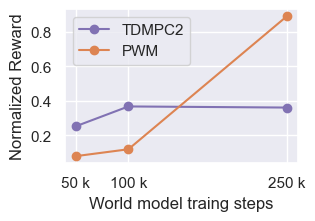

In [249]:
scores = {}
Y = 50_000 # number of policy steps
runs = [50_000, 100_000, 250_000]
tasks = [hopper_stand_df, hopper_hop_df, pendulum_swingup_df, cartpole_swingup_df, walker_run_df]
for run in runs:
    sc = []
    for task in tasks:
        sl = task[task.Step == Y]
        sl = sl.filter(like="/" + str(run) + ".pt")
        sc.append(sl.values)
    scores[run] = np.median(np.array(sc), axis=-1) # median is done to remove stds
scores

rps = {} # reward per second
for k,v in scores.items():
    rps[k] = np.mean(v)

f, ax = plt.subplots(figsize=(3,2))

norm = 1000.0
ax.plot(runs, np.array(list(rps.values()))/norm, marker="o", color=colors["TDMPC2"], label="TDMPC2")
fake_data = np.array([80, 120, 890])
ax.plot(runs, fake_data/norm, marker="o", color=colors["PWM"], label="PWM")
ax.set_xticks(runs)
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set_xlabel("World model traing steps")
ax.set_ylabel("Normalized Reward")
ax.set_xticks(runs)
plt.legend()
plt.savefig("../figures/learning_rate_abl.pdf", bbox_inches="tight", pad_inches=0)

## World model training horizon

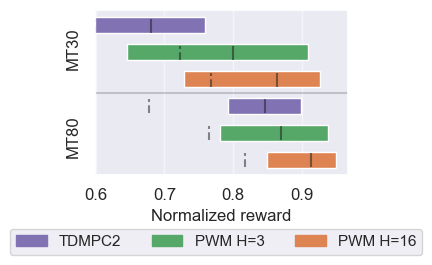

In [25]:
# Load data and process into metrics
norm = 1000

pwm30_data = pd.read_csv("data/mt30_results.csv")
pwm30_data["score"] = pwm30_data.episode_reward/norm

pwm30_h3_data = pd.read_csv("data/mt30_results_h3.csv")
pwm30_h3_data["score"] = pwm30_h3_data.episode_reward/norm

pwm80_data = pd.read_csv("data/mt80_results.csv")
pwm80_data["score"] = pwm80_data.episode_reward/norm
idx = pwm80_data.task.str.startswith("mw")
pwm80_data.loc[idx, "score"] = pwm80_data[idx].episode_success

pwm80_h3_data = pd.read_csv("data/mt80_results_h3.csv")
pwm80_h3_data["score"] = pwm80_h3_data.episode_reward/norm
idx = pwm80_h3_data.task.str.startswith("mw")
pwm80_h3_data.loc[idx, "score"] = pwm80_h3_data[idx].episode_success

tdmpc30_data = pd.read_csv("data/tdmpc2_mt30_scores.csv")
seeds = tdmpc30_data.seed.max()+1
tdmpc30_scores = tdmpc30_data.episode_reward.values.reshape((-1, seeds, 1))

tdmpc80_data = pd.read_csv("data/tdmpc2_mt80_scores.csv")
tdmpc80_data["score"] = tdmpc80_data.episode_reward/norm
idx = tdmpc80_data.task.str.startswith("mw")
tdmpc80_data.loc[idx, "score"] = tdmpc80_data[idx].episode_success
seeds = tdmpc80_data.seed.max()+1
tdmpc80_scores = tdmpc80_data.score.values.reshape((-1, seeds, 1))

# score dict is {algo: np.array num_exp x seeds x episode_rewards}
score_dict = {
            "TDMPC230": tdmpc30_scores/norm,
            "TDMPC280": tdmpc80_scores,
            "PWM30": pwm30_data.score.values.astype(np.float32)[...,None][...,None],
            "PWM80": pwm80_data.score.values.astype(np.float32)[...,None][...,None],
            "PWMH330": pwm30_h3_data.score.values.astype(np.float32)[...,None][...,None],
            "PWMH380": pwm80_h3_data.score.values.astype(np.float32)[...,None][...,None],
            }

iqm_scores, iqm_cis = rly.get_interval_estimates(score_dict, iqm, reps=reps)
mean_scores = {algo: np.mean(scores) for algo,scores in score_dict.items()} 

# Plot data
colors = sns.color_palette()

# baselines are PPO, SAC, TDMPC (no planning), TDMPC plannig, SHAC, FOWM
colors = {#"SHAC": colors[0],
         # "PPO": colors[2],
         "TDMPC230": colors[4],
         "TDMPC280": colors[4],
         "PWM30": colors[1],
         "PWM80": colors[1],
         "PWMH330": colors[2],
         "PWMH380": colors[2],
         "SAC": colors[3],
         # "PWM+planning": colors[5],
         "DreamerV3": colors[6]}

fig, ax1 = plt.subplots(1,1, figsize=(3,2.5))

# plot CI and median
h=0.6
labels = ["TDMPC230", "PWMH330", "PWM30"][::-1]
for idx, alg in enumerate(labels):
    idx += 3
    ax1.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], color=colors[alg])
    ax1.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax1.vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

labels = ["TDMPC280", "PWMH380", "PWM80"][::-1]
for idx, alg in enumerate(labels):
    ax1.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], color=colors[alg])
    ax1.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax1.vlines(x=mean_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed",
        )

ax1.set_xlabel("Normalized reward")
ax1.grid(False)    
ax1.grid(True, axis='x', alpha=0.5)    
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize='medium')

xlim = ax1.get_xlim()
ax1.hlines(2.5, xlim[0], xlim[1], color="k", alpha=0.2)
ax1.set_xlim(xlim)
fig.text(0, 0.7, "MT30", rotation=90)
fig.text(0, 0.35, "MT80", rotation=90)


# set legened helpers
fancy_legend = [mpatches.Patch(color=colors["TDMPC230"], label="TDMPC2"),
               mpatches.Patch(color=colors["PWMH330"], label="PWM H=3"),
               mpatches.Patch(color=colors["PWM80"], label="PWM H=16")]

plt.tight_layout()
fig.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, 0.0), fancybox=True, shadow=False, ncol=len(fancy_legend))
plt.savefig("../figures/horizon_ablation.pdf", bbox_inches="tight", pad_inches=0)